In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sp_inference import processes, model, logging
from sp_inference.utilities import general as utils
from sp_inference.postprocessing import visualization as viz, data_types as dt
import hippylib.utils.fenics_enhancer as fee

In [ ]:
logSettings = {
    "output_directory":           "04_met_moments",
    "verbose":                    True
}

dataSettings = {
    "process_type":               "Dr31Di20Process",
    "drift_parameters":           [2, 3],
    "diffusion_parameters":       [1, 2],
    "standard_deviation":         0.001,
    "rng_seed":                   0,
    "num_points":                 50,
    "domain_bounds":              [-1.5, 1.5]
}

modelSettings = {
    "params_to_infer":            "all",
    "model_type":                 "mean_exit_time_moments",
    "is_stationary":              True
}

priorSettings = {
    "mean_function":              ["-x", 2.5],
    "variance":                   ["1 + 0.5*x**2", "1 + 0.5*x**2"],
    "correlation_length":         [1, "1+x**2"],
    "robin_bc":                   [True, True],
    "robin_bc_const":             [5, 5]
}

feSettings = {
    "num_mesh_points":            500,
    "boundary_locations":         [-1.5, 1.5],
    "boundary_values":            [(0, 0), (0, 0)],
    "element_degrees":            [1, 1]
}

solverSettings = {
    "rel_tolerance":              1e-8,
    "abs_tolerance":              1e-12,
    "max_iter":                   50,
    "GN_iter":                    5,
    "c_armijo":                   1e-4,
    "max_backtracking_iter":      10
}

hessianSettings = {
    "num_eigvals":                20,
    "num_oversampling":           5
}

In [ ]:
try:
    os.system('rm -r ' + logSettings["output_directory"])
except:
    pass

logger = logging.Logger(logSettings["verbose"],
                        logSettings["output_directory"])

In [ ]:
randGenerator = np.random.default_rng(dataSettings["rng_seed"])
randLocs = randGenerator.uniform(*dataSettings["domain_bounds"], dataSettings["num_points"])
dataSettings["domain_points"] = randLocs

processType = processes.get_process(dataSettings["process_type"])
process = processType(dataSettings["drift_parameters"],
                      dataSettings["diffusion_parameters"],
                      logger)

forwardNoisy, forwardExact = process.generate_data_mean_exit_time_moments(dataSettings["domain_points"],
                                                                          dataSettings["standard_deviation"], 
                                                                          dataSettings["rng_seed"], 
                                                                          feSettings)
exactDrift = process.compute_drift(randLocs)
exactDiffusion = process.compute_squared_diffusion(randLocs)
exactParamValues = [exactDrift, exactDiffusion]

misFitSettings = {
    "data_locations": randLocs,
    "data_values": forwardNoisy,
    "data_var": (dataSettings["standard_deviation"]**2,)*2
}

In [ ]:
inferenceModel = model.SDEInferenceModel(modelSettings,
                                         priorSettings,
                                         feSettings,
                                         misFitSettings,
                                         logger=logger)

priorMeanData, priorVarianceData, priorForwardData = inferenceModel.get_prior_info("Randomized")
mapMeanData, mapVarianceData, mapForwardData, hessEigVals \
    = inferenceModel.compute_gr_posterior(solverSettings, hessianSettings)

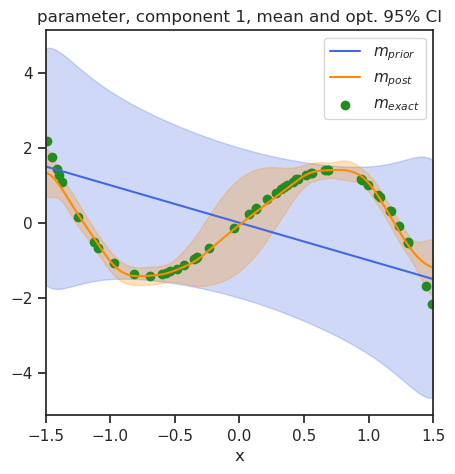

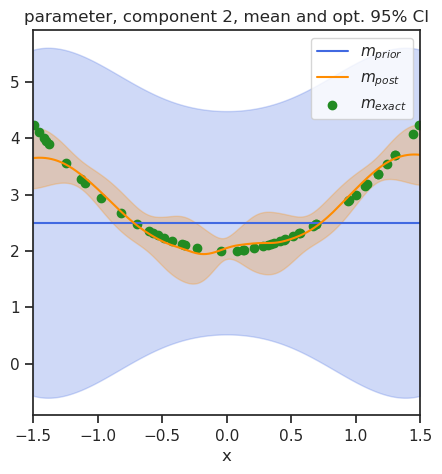

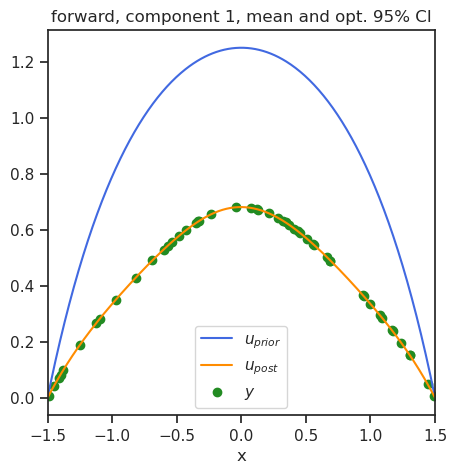

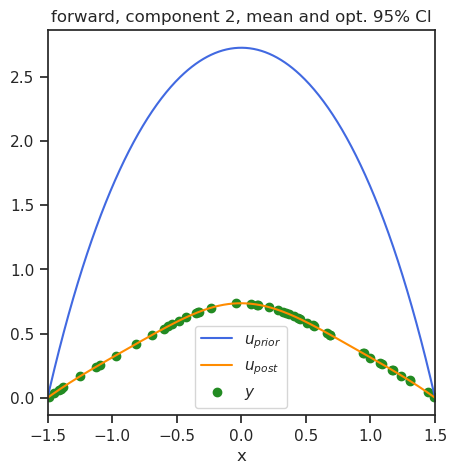

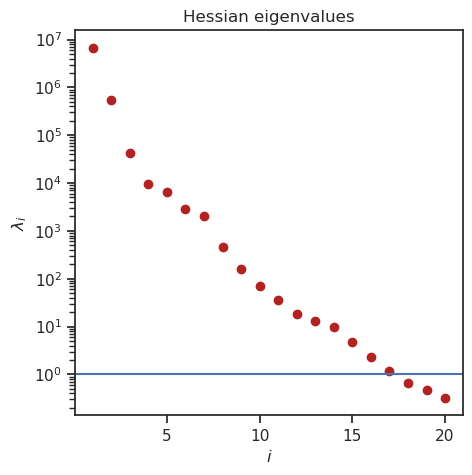

In [19]:
forward_data = np.split(forwardNoisy, forwardNoisy.shape[1], axis=1)
prior_mean_list = np.split(priorMeanData[1], priorMeanData[1].shape[1], axis=1)
prior_var_list = np.split(priorVarianceData[1], priorVarianceData[1].shape[1], axis=1)
map_mean_list = np.split(mapMeanData[1], mapMeanData[1].shape[1], axis=1)
map_var_list = np.split(mapVarianceData[1], mapVarianceData[1].shape[1], axis=1)
prior_forward_list = fee.convert_np_array_fe2np(priorForwardData[1], inferenceModel.funcSpaces[1])
map_forward_list = fee.convert_np_array_fe2np(mapForwardData[1], inferenceModel.funcSpaces[1])

parameter_domain = dt.Grid1D(priorMeanData[0])
forward_domain = dt.Grid1D(priorMeanData[0])
data_domain = dt.Grid1D(randLocs)

prior_mean_components = dt.StationaryFieldComponent.from_iterable(parameter_domain, prior_mean_list)
prior_var_components = dt.StationaryFieldComponent.from_iterable(parameter_domain, prior_var_list)
prior_forward_component = dt.StationaryFieldComponent.from_iterable(forward_domain, prior_forward_list)
map_mean_components = dt.StationaryFieldComponent.from_iterable(parameter_domain, map_mean_list)
map_var_components = dt.StationaryFieldComponent.from_iterable(parameter_domain, map_var_list)
map_forward_component = dt.StationaryFieldComponent.from_iterable(forward_domain, map_forward_list)
exact_param_component = dt.StationaryFieldComponent.from_iterable(data_domain, exactParamValues)
data_component = dt.StationaryFieldComponent.from_iterable(data_domain, forward_data)

prior_mean_field = dt.StationaryField(prior_mean_components)
prior_var_field = dt.StationaryField(prior_var_components)
prior_forward_field = dt.StationaryField(prior_forward_component)
map_mean_field = dt.StationaryField(map_mean_components)
map_var_field = dt.StationaryField(map_var_components)
map_forward_field = dt.StationaryField(map_forward_component)
exact_param_field = dt.StationaryField(exact_param_component)
data_field = dt.StationaryField(data_component)

prior_param_data = dt.InferenceData(label=r'$m_{prior}$',
                                    field=prior_mean_field,
                                    variance_field=prior_var_field)
posterior_param_data = dt.InferenceData(label=r'$m_{post}$',
                                        field=map_mean_field,
                                        variance_field=map_var_field)
exact_param_data = dt.InferenceData(label=r'$m_{exact}$',
                                    field=exact_param_field,
                                    is_point_data=True)
prior_forward_data = dt.InferenceData(label=r'$u_{prior}$',
                                      field=prior_forward_field)
posterior_forward_data = dt.InferenceData(label=r'$u_{post}$',
                                          field=map_forward_field)
point_data = dt.InferenceData(label=r'$y$',
                              field=data_field,
                              is_point_data=True)

plt.close('all')
results_dir = os.path.join(logSettings["output_directory"], "visualization")
os.makedirs(results_dir, exist_ok=True)
visualizer = viz.Visualizer()
visualizer.plot_inference_data(prior_param_data,
                               posterior_param_data,
                               exact_param_data,
                               path_name=os.path.join(results_dir,"parameter"))
visualizer.plot_inference_data(prior_forward_data,
                               posterior_forward_data,
                               point_data,
                               path_name=os.path.join(results_dir,"forward"))
viz.plot_hessian_data(hessEigVals, path_name=results_dir)

In [18]:
priorForwardData[0].shape

(1002,)